## Fill missing glaciers and add basin id to provide region netcdf

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
from oggm.utils import mkdir
import oggm
import geopandas as gpd
import sys
import json

In [13]:
scenarios = ['stab_T12','oversh_T20OS15', 'oversh_T25OS15', 'oversh_T30OS15', 'stab_T15', 'stab_T20', 'stab_T25', 'stab_T30']

In [14]:
from oggm import utils
# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
for rgi_reg in np.array([ 1,  2,  3,  4, 5, 6,  7,  8,  9,
                         10, 11, 12, 13, 14, 15, 16, 17, 18, 19]):
    #print(rgi_reg)
    if rgi_reg < 10:
        rgi_reg_s = f'0{rgi_reg}'
    else:
        rgi_reg_s = f'{rgi_reg}'
    odf_reg = odf.loc[odf.O1Region == rgi_reg_s]
    print(rgi_reg, len(odf_reg.loc[odf_reg.IsTidewater]))

1 199
2 0
3 258
4 68
5 903
6 0
7 141
8 0
9 375
10 2
11 0
12 0
13 0
14 0
15 0
16 0
17 218
18 0
19 1356


In [15]:
# get basin information 
b_per_Preg = json.load(open('/home/www/lschuster/provide/provide_glacier_regions/basin_ids_per_provide_region.json'))
r_per_basin = json.load(open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json'))

df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
print(len(df_itmix))

preg_list = []
for j, pi in enumerate(np.arange(1,14,1)):
    if pi<10:
        Preg = f'P0{pi}'
    else:
        Preg = f'P{pi}'
    preg_list.append(Preg)
    
pd_provide_reg = pd.DataFrame(index=preg_list)

rgi_ids_per_provide_region_dict = {}
Preg_dict = {}
for pi in np.arange(1,14,1):
    f = open('/home/www/lschuster/provide/provide_glacier_regions/rgi_ids_per_provide_region.json')
    if pi<10:
        Preg = f'P0{pi}'
    else:
        Preg = f'P{pi}'
    rgis_basin = json.load(f)[Preg]
    # remove connectivity level 2 glaciers only important for P03 (Greenland)
    rgis_basin = odf.loc[rgis_basin].loc[odf.loc[rgis_basin].Connect <2].index.values
    rgis_basin = list(set(rgis_basin))
    
    pd_provide_reg.loc[Preg,'n glaciers'] = int(len(rgis_basin))
    vol_ratio = 100*df_itmix.loc[rgis_basin]['vol_itmix_m3'].sum()/df_itmix['vol_itmix_m3'].sum()
    pd_provide_reg.loc[Preg,'Initial volume relative'] = vol_ratio
    rgi_ids_per_provide_region_dict[Preg] = rgis_basin
    Preg_dict[Preg] = odf.loc[rgis_basin]
    Preg_dict[Preg]['Area'] = Preg_dict[Preg].Area.values *1e6 # km2 to m2
    
today = '19/06/2023' #'15/05/2023'
bc = 'bc_1980_2019' #'bc_2000_2019'
folder_path = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output/provide_reg/w5e5_gcm_merged_from_2000_{bc}/'

216502


In [16]:
#rgi_ids_per_provide_region_dict['P06']

In [17]:
for Preg in preg_list:
    with xr.open_dataset(folder_path+f'{Preg}/provide_reg_{Preg}_oversh_T30OS15_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_{bc}.nc') as ds:
        ds = ds.volume.sel(time=[2000,2499]).load()
    sel_runaway = ds.where(((ds.isel(time=-1) / ds.isel(time=0)) >= 2) & (ds.isel(time=-1) / ds.isel(time=-1).sum(dim='rgi_id') >0.001)).dropna(dim='rgi_id')
    print(Preg, len(sel_runaway.rgi_id), print(sel_runaway.rgi_id.values))
    
    try:
        print(max((sel_runaway.isel(time=-1)/sel_runaway.isel(time=0)).values))
    except:
        pass

[]
P01 0 None
[]
[]
P02 0 None
[]
['RGI60-05.10983']
P03 1 None
[[2.374017]]
[]
P04 0 None
[]
['RGI60-07.00608' 'RGI60-07.00061' 'RGI60-07.00551' 'RGI60-07.00424'
 'RGI60-07.00552' 'RGI60-07.00033' 'RGI60-07.00607' 'RGI60-07.00034'
 'RGI60-07.00423' 'RGI60-09.00468' 'RGI60-09.00471' 'RGI60-09.00510'
 'RGI60-09.00483']
P05 13 None
[[2.1843154 2.2102644 2.158272  2.1147437 2.007953  2.6493156 4.7771316
  2.8181496 2.7228234 2.12951   2.2660534 2.306444  2.7596655]]
['RGI60-10.04979' 'RGI60-10.03210' 'RGI60-10.03634' 'RGI60-10.04201'
 'RGI60-10.05009' 'RGI60-10.04942' 'RGI60-10.04237' 'RGI60-10.04175'
 'RGI60-10.03119' 'RGI60-10.05072' 'RGI60-10.04625' 'RGI60-10.05074'
 'RGI60-10.04623' 'RGI60-10.04852' 'RGI60-10.04955' 'RGI60-01.08444']
P06 16 None
[[  56.786987    39.991814     2.76335   1325.7487      46.14463
    13.495721     7.1059785  246.78564      6.232221    29.399094
    16.865566    38.224213    18.057398    16.376669    33.978203
     6.7930512]]
[]
P07 0 None
[]
['RGI60-12.0

In [11]:
rgi_ids_problems = list(set(dv_runaway.dropna(dim='rgi_id').rgi_id.values) - set(dv.dropna(dim='rgi_id').rgi_id.values))

NameError: name 'dv_runaway' is not defined

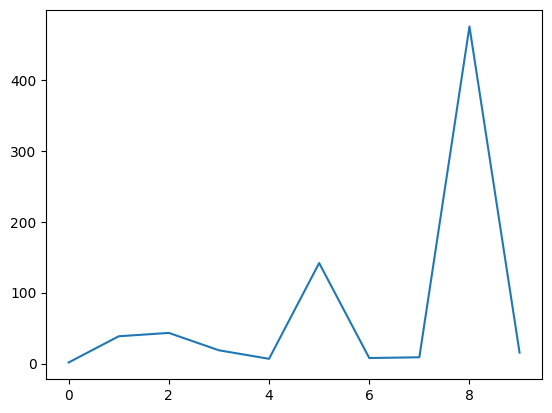

In [31]:
plt.plot((dv_runaway.sel(rgi_id = rgi_ids_problems).isel(time=-1)/dv_runaway.sel(rgi_id = rgi_ids_problems).isel(time=0)).squeeze())

In [21]:
dv.dropna(dim='rgi_id')

<xarray.DataArray 'volume' (scenario: 1, gcm: 1, time: 500, rgi_id: 15802)>
array([[[[1.838302e+05, ..., 2.019540e+05],
         ...,
         [9.207010e+01, ..., 0.000000e+00]]]], dtype=float32)
Coordinates:
  * time             (time) float64 2e+03 2.001e+03 ... 2.498e+03 2.499e+03
  * rgi_id           (rgi_id) object 'RGI60-17.12641' ... 'RGI60-17.05341'
    hydro_year       (time) int64 ...
    hydro_month      (time) int64 ...
    calendar_year    (time) int64 ...
    calendar_month   (time) int64 ...
  * gcm              (gcm) object 'GFDL-ESM2M'
  * scenario         (scenario) object 'stab_T15'
    bias_correction  <U12 'bc_2000_2019'
    provide_region   <U3 'P11'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'
Attributes:
    description:  Total glacier volume
    unit:         m 3

In [12]:
dv.rgi_id

<xarray.DataArray 'rgi_id' (rgi_id: 15908)>
array(['RGI60-17.12641', 'RGI60-17.01956', 'RGI60-17.06816', ...,
       'RGI60-17.02452', 'RGI60-17.05341', 'RGI60-17.01810'], dtype=object)
Coordinates:
  * rgi_id           (rgi_id) object 'RGI60-17.12641' ... 'RGI60-17.01810'
    bias_correction  object ...
    provide_region   object ...
    OGGM_version     object ...
Attributes:
    description:  RGI glacier identifier

In [14]:
dv_runaway.dropna(dim='rgi_id')

<xarray.DataArray 'volume' (scenario: 1, gcm: 1, time: 500, rgi_id: 15812)>
array([[[[183830.25, ..., 201953.98],
         ...,
         [     0.  , ...,      0.  ]]]], dtype=float32)
Coordinates:
  * time             (time) float64 2e+03 2.001e+03 ... 2.498e+03 2.499e+03
  * rgi_id           (rgi_id) object 'RGI60-17.12641' ... 'RGI60-17.05341'
    hydro_year       (time) int64 ...
    hydro_month      (time) int64 ...
    calendar_year    (time) int64 ...
    calendar_month   (time) int64 ...
  * gcm              (gcm) object 'GFDL-ESM2M'
  * scenario         (scenario) object 'oversh_T25OS15'
    bias_correction  object ...
    provide_region   object ...
    OGGM_version     object ...
Attributes:
    description:  Total glacier volume
    unit:         m 3

In [10]:
dv.dropna(dim='rgi_id')

<xarray.DataArray 'volume' (scenario: 1, gcm: 1, time: 500, rgi_id: 15802)>
array([[[[1.838302e+05, ..., 2.019540e+05],
         ...,
         [9.207010e+01, ..., 0.000000e+00]]]], dtype=float32)
Coordinates:
  * time             (time) float64 2e+03 2.001e+03 ... 2.498e+03 2.499e+03
  * rgi_id           (rgi_id) object 'RGI60-17.12641' ... 'RGI60-17.05341'
    hydro_year       (time) int64 2000 2001 2002 2003 ... 2496 2497 2498 2499
    hydro_month      (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
    calendar_year    (time) int64 2000 2001 2002 2003 ... 2496 2497 2498 2499
    calendar_month   (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
  * gcm              (gcm) object 'GFDL-ESM2M'
  * scenario         (scenario) object 'stab_T15'
    bias_correction  <U12 'bc_2000_2019'
    provide_region   <U3 'P11'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'
Attributes:
    description:  Total glacier volume
    unit:         m 3

In [8]:
odf.loc[dv.rgi_id].Area.sum()

1194.942

In [9]:
odf.loc[dt.where(dt).dropna(dim='rgi_id').rgi_id].sort_values(by='Area').iloc[-2:].Area

RGIId
RGI60-10.00006    12.966
RGI60-10.00002    48.144
Name: Area, dtype: float64

In [10]:
df_itmix.loc[dt.where(dt).dropna(dim='rgi_id').rgi_id].sort_values(by='vol_itmix_m3').iloc[-20:]

,vol_itmix_m3,vol_bsl_itmix_m3
RGIId,,
RGI60-10.00022,1.093970e+06,0.000000e+00
RGI60-10.00093,1.121883e+06,0.000000e+00
RGI60-10.00081,1.268080e+06,0.000000e+00
RGI60-10.00110,1.270524e+06,0.000000e+00
RGI60-10.00075,1.608527e+06,0.000000e+00
RGI60-10.00082,1.701956e+06,0.000000e+00
RGI60-10.00054,1.859307e+06,0.000000e+00
RGI60-10.00087,1.941263e+06,0.000000e+00
RGI60-10.04628,2.149939e+06,0.000000e+00


In [11]:
df_itmix.loc[dt.where(dt).dropna(dim='rgi_id').rgi_id].sort_values(by='vol_itmix_m3').iloc[-20:]

,vol_itmix_m3,vol_bsl_itmix_m3
RGIId,,
RGI60-10.00022,1.093970e+06,0.000000e+00
RGI60-10.00093,1.121883e+06,0.000000e+00
RGI60-10.00081,1.268080e+06,0.000000e+00
RGI60-10.00110,1.270524e+06,0.000000e+00
RGI60-10.00075,1.608527e+06,0.000000e+00
RGI60-10.00082,1.701956e+06,0.000000e+00
RGI60-10.00054,1.859307e+06,0.000000e+00
RGI60-10.00087,1.941263e+06,0.000000e+00
RGI60-10.04628,2.149939e+06,0.000000e+00


In [18]:
for Preg in preg_list:
    print(f'Preg: {Preg} started')
    #for scenario in scenarios:
    ds_l_scenarios = []
    #ds_l_scenarios_per_glacier = []
    # add basin id to rgi ids
    # should have the same order as ds_scenarios_per_glac
    ds_l_scenarios_dict={}
    pd_rgis_b = pd.DataFrame(index = Preg_dict[Preg].index.values)
    # if there is no basin, the basin_id is just np.NaN
    pd_rgis_b['basin_id'] = np.NaN
    if len(b_per_Preg[Preg]) == 0:
        pass
    else:
        for basin in b_per_Preg[Preg]:
            pd_rgis_b.loc[r_per_basin[str(basin)]] = str(basin)
            ds_l_scenarios_dict[basin] = []
    for scenario in scenarios:
        path = folder_path + f'{Preg}/provide_reg_{Preg}_{scenario}_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_{bc}.nc'
        ds_sel = xr.open_dataset(path)
        #ds_sel = ds.sel(scenario=scenario)
        # need to remove those that are not working when merging them later together 
        ds_sel = ds_sel.dropna(dim='rgi_id', how='all')
        ds_sel = ds_sel.load()
        Preg_working = ds_sel.volume.isel(time=0).dropna(dim='rgi_id').rgi_id.values

        bad_rgi = list(set(Preg_dict[Preg].index).difference(Preg_working))

        bad = Preg_dict[Preg].loc[bad_rgi]  
        good = Preg_dict[Preg].loc[Preg_working]  # working glaciers
        bad_vs_total_ratio = bad.Area.sum() / (good.Area.sum() + bad.Area.sum())
        print(bad_vs_total_ratio)
        #bad_glacier_count_perc = (len(bad)/len(good))
        #print('Correcting for {:.2f}% bad area'.format(bad_ratio * 100))
        assert len(bad)+len(good) == len(Preg_dict[Preg].index)

        # create dummy xarray dataset with empty data for the missing glaciers
        # that will be filled afterwards
        ds_dummy = ds_sel.isel(rgi_id=0).load().copy(deep=True)
        ds_dummy['volume'].data[...] = np.NaN
        ds_dummy['runoff'].data[...] = np.NaN
        ds_dummy['runoff_monthly'].data[...] = np.NaN
        ds_dummy['area'].data[...] = np.NaN
        #ds_dummy = ds_dummy.drop('rgi_id')
        #ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index}).transpose()
        ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index.values}).transpose()
        # NEW: also need to add the coords values -> maybe 
        ds_dummy.coords['rgi_id'] = bad.index.values
        # add the dummy xarray dataset to the existing glaciers
        ds_sel_full = xr.concat([ds_sel, ds_dummy], dim='rgi_id')

        # Repair the missing glaciers
        ds_rep_sel = ds_sel_full.copy(deep=True)
        ds_rep_sel = ds_rep_sel.squeeze()
        ds_index = ds_rep_sel.rgi_id.data
        # need to loop over every glacier 
        for rid, g in bad.iterrows():
            area_diff = np.abs(good.Area - g.Area) / g.Area
            # if possible, take all glacers of that RGI region that 
            # have a smaller relative area difference than 1 %
            sel = area_diff.loc[area_diff < 0.01]
            if len(sel) < 3:
                # if less than 3 glaciers have a similar area,
                # take instead the 9 area-most similar glaciers
                sel = area_diff.sort_values().iloc[:9]
            # Now, we take the average over the selected area-similar glaciers
            # and add them as fake statistics for that missing glacier
            # (in our case it is area and volume that that 
            # are estimated for each simulation year like that)
            new = ds_sel.sel(rgi_id=sel.index).mean(dim='rgi_id').squeeze()
            rep_id = np.nonzero(ds_index == rid)[0][0]
            for vn in ds_rep_sel.data_vars:
                ds_rep_sel[vn].data[...,rep_id] = new[vn].data

        # Convert to f64 for exact summing
        ds_rep_sel = ds_rep_sel.astype(np.float64)
        # add some statistics about how much we had to fill up this RGI region
        ds_rep_sel.attrs['ratio_area_missing_filled_vs_total'] = bad_vs_total_ratio #*100
        ds_rep_sel.attrs['n_glaciers_missing_filled'] = len(bad)

        # create a dataset that has the same form as the "raw" uncorrected dataset
        # but we add an information that the data was corrected
        ds_rep_sel.attrs['creation_date'] = str(today)
        ds_rep_sel.attrs['provide_region'] = Preg
        ds_rep_sel.attrs['scenario'] = scenario
        # for gfdl I used the unofficial dev-branch that's why it can be different in the raw files
        # but the code should be the same
        #ds_rep_sel.attrs['oggm_version'] = '1.6' 
        add = ('\n(missing glaciers were filled with average glacier' 
               'statistics from similar-area glaciers of that provide region)')
        ds_rep_sel.attrs['information'] = 'OGGM v1.6.1 (v2023.3, W5E5_spinup)'+ add
        # check if there are any NaN values  (should not be the case, all glaciers should have been filled!)
        assert set(ds_rep_sel.dropna(dim='rgi_id', how='all').rgi_id.values) == set(Preg_dict[Preg].index)
        # keep the per glacier files, but also directly compute regional summed up filled files 
        ds_rep_sel_sum = ds_rep_sel.sum(dim='rgi_id', keep_attrs=True)
        ### NEED TO ALSO SAVE THE SUM of EACH BASIN
        ds_rep_sel = ds_rep_sel.assign_coords(basin_id =("rgi_id", pd_rgis_b.loc[ds_rep_sel.rgi_id]['basin_id'].values))
        if len(b_per_Preg[Preg]) == 0:
            pass
        else:
            dict_basin_sum = {}
            for basin in b_per_Preg[Preg]:
                ds_l_scenarios_dict[basin].append(ds_rep_sel.sel(rgi_id=ds_rep_sel.rgi_id.basin_id == str(basin)).sum(dim='rgi_id'))

        # TODO 
        ds_l_scenarios.append(ds_rep_sel_sum)
        #ds_l_scenarios_per_glacier.append(ds_rep_sel)
        ds_sel.close()
    ds_scenarios = xr.concat(ds_l_scenarios, dim='scenario')
    ## save the data
    out_path = folder_path + f'{Preg}/filled_sum_provide_reg_{Preg}_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_{bc}.nc'
    ds_scenarios.to_netcdf(out_path)
    
    for basin in b_per_Preg[Preg]:
        ds_scenarios_b_d = xr.concat(ds_l_scenarios_dict[basin], dim='scenario')
        out_path = folder_path + f'{Preg}/filled_sum_basin_{basin}_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_{bc}.nc'
        ds_scenarios_b_d.to_netcdf(out_path)

    # check if there are no NaN values anymore... 
    #assert np.all(~np.isnan(ds_scenarios_per_glac.volume.values))
    
    # add basin id to rgi ids
    # should have the same order as ds_scenarios_per_glac
    #ds_scenarios_per_glac = xr.concat(ds_l_scenarios_per_glacier, dim='scenario')
    #pd_rgis_b = pd.DataFrame(index = ds_scenarios_per_glac.rgi_id)
    # if there is no basin, the basin_id is just np.NaN
    #pd_rgis_b['basin_id'] = np.NaN
    #for basin in b_per_Preg[Preg]:
    #    pd_rgis_b.loc[r_per_basin[str(basin)]] = str(basin)
    #ds_scenarios_per_glac = ds_scenarios_per_glac.assign_coords(basin_id =("rgi_id", pd_rgis_b.loc[ds_scenarios_per_glac.rgi_id]['basin_id'].values))

    # this is how you can select the glaciers of a specific basin late  .. 
    # ds_scenarios_per_glac.sel(rgi_id=ds_scenarios_per_glac.rgi_id.basin_id == str(basin))

    
    
    
    # these files are too large due to monthly runoff files and I won't need them
    #out_path = folder_path + f'{Preg}/filled_per_glacier_provide_reg_{Preg}_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_bc_2000_2019.nc'
    #ds_scenarios_per_glac.to_netcdf(out_path)
    
    # close the datasets to be sure ... 
    ds_rep_sel_sum.close()
    ds_rep_sel.close()
    ds_sel_full.close()
    


Preg: P10 started
0.0003186987495786023
0.0002878569351032537
0.0002878569351032537
0.0002878569351032537
0.0002878569351032537
0.0002878569351032537
0.0002878569351032537
0.0002878569351032537
Preg: P11 started
0.0030928591719482906
0.003000875324678855
0.0029729437685445826
0.0029676089092829268
0.0030558889370649713
0.0029871813865740963
0.0028577176044918837
0.00280039335242556


In [54]:
basin_rapel = '3423'
#dtest = xr.open_dataset(folder_path + f'{Preg}/filled_sum_basin_{basin_rapel}_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_{bc}.nc')

In [57]:
scenario = 'stab_T12'
path = folder_path + f'{Preg}/provide_reg_{Preg}_{scenario}_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_{bc}.nc'
dtest = xr.open_dataset(path)
dtest = dtest.assign_coords(basin_id =("rgi_id", pd_rgis_b.loc[dtest.rgi_id]['basin_id'].values))

drapel_basin = dtest.sel(rgi_id=dtest.rgi_id.basin_id == str(basin_rapel))

In [58]:
drapel_basin

<xarray.Dataset>
Dimensions:              (scenario: 1, gcm: 1, time: 500, rgi_id: 246,
                          month_2d: 12)
Coordinates: (12/14)
  * time                 (time) float64 2e+03 2.001e+03 ... 2.498e+03 2.499e+03
  * rgi_id               (rgi_id) object 'RGI60-17.01165' ... 'RGI60-17.01149'
    hydro_year           (time) int64 ...
    hydro_month          (time) int64 ...
    calendar_year        (time) int64 ...
    calendar_month       (time) int64 ...
    ...                   ...
  * gcm                  (gcm) object 'GFDL-ESM2M'
  * scenario             (scenario) object 'stab_T12'
    bias_correction      object ...
    provide_region       object ...
    OGGM_version         object ...
    basin_id             (rgi_id) object '3423' '3423' '3423' ... '3423' '3423'
Data variables:
    runoff               (scenario, gcm, time, rgi_id) float32 ...
    melt_off_on          (scenario, gcm, time, rgi_id) float32 ...
    volume               (scenario, gcm, time, rgi_id) float32 ...
    area                 (scenario, gcm, time, rgi_id) float32 ...
    runoff_monthly       (scenario, gcm, time, month_2d, rgi_id) float32 ...
    melt_off_on_monthly  (scenario, gcm, time, month_2d, rgi_id) float32 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1.dev26+gf8a1745
    calendar:       365-day no leap
    creation_date:  2023-07-03 11:49:02

In [73]:
drapel_basin.drop_sel

Signature:
drapel_basin.drop(
    labels=None,
    dim=None,
    *,
    errors='raise',
    **labels_kwargs,
)
Docstring:
Backward compatible method based on `drop_vars` and `drop_sel`

Using either `drop_vars` or `drop_sel` is encouraged

See Also
--------
Dataset.drop_vars
Dataset.drop_sel
File:      ~/.local/lib/python3.10/site-packages/xarray/core/dataset.py
Type:      method


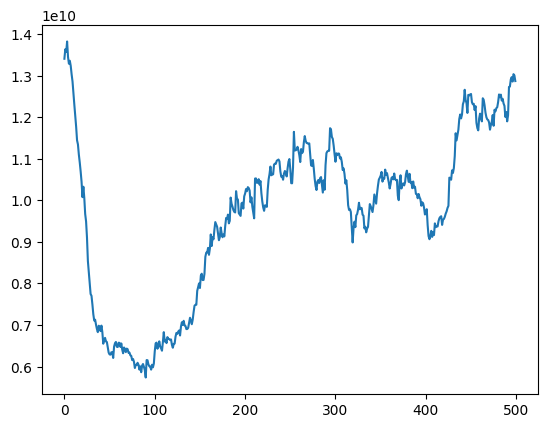

In [75]:
plt.plot(drapel_basin.volume.sum(dim='rgi_id').squeeze())

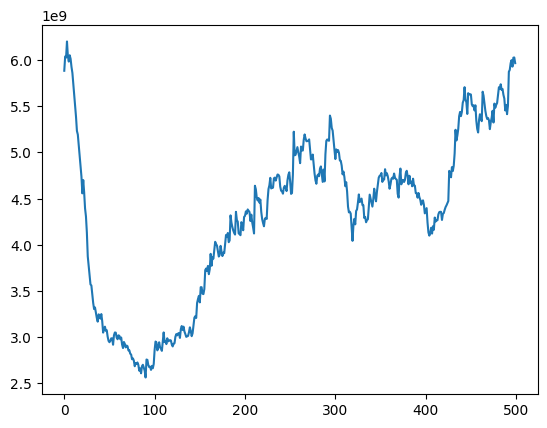

In [74]:
plt.plot(drapel_basin.drop_sel(rgi_id=rgi_max).volume.sum(dim='rgi_id').squeeze())

In [81]:
drapel_b_t

<xarray.Dataset>
Dimensions:              (scenario: 1, gcm: 1, time: 500, rgi_id: 226,
                          month_2d: 12)
Coordinates: (12/14)
  * time                 (time) float64 2e+03 2.001e+03 ... 2.498e+03 2.499e+03
  * rgi_id               (rgi_id) object 'RGI60-17.01165' ... 'RGI60-17.01149'
    hydro_year           (time) int64 2000 2001 2002 2003 ... 2497 2498 2499
    hydro_month          (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10
    calendar_year        (time) int64 2000 2001 2002 2003 ... 2497 2498 2499
    calendar_month       (time) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    ...                   ...
  * gcm                  (gcm) object 'GFDL-ESM2M'
  * scenario             (scenario) object 'stab_T12'
    bias_correction      <U12 'bc_1980_2019'
    provide_region       <U3 'P11'
    OGGM_version         <U22 'OGGM_v161_gdirs_2023.3'
    basin_id             (rgi_id) object '3423' '3423' '3423' ... '3423' '3423'
Data variables:
    runoff               (scenario, gcm, time, rgi_id) float32 1.61e+09 ... nan
    melt_off_on          (scenario, gcm, time, rgi_id) float32 1.6e+09 ... nan
    volume               (scenario, gcm, time, rgi_id) float32 6.592e+07 ... 0.0
    area                 (scenario, gcm, time, rgi_id) float32 1.225e+06 ... 0.0
    runoff_monthly       (scenario, gcm, time, month_2d, rgi_id) float32 7.66...
    melt_off_on_monthly  (scenario, gcm, time, month_2d, rgi_id) float32 7.63...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1.dev26+gf8a1745
    calendar:       365-day no leap
    creation_date:  2023-07-03 11:49:02

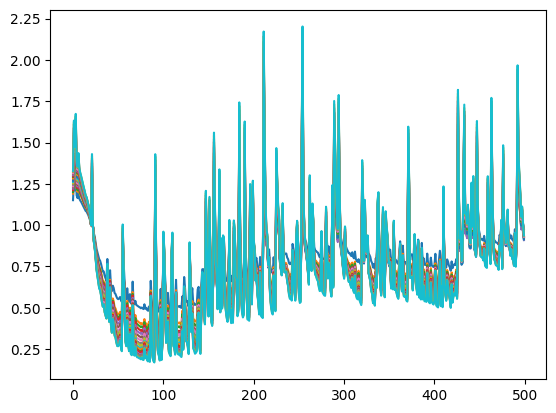

In [89]:
drapel_b_t = drapel_basin.copy()
for r in np.arange(0,20):
    rgi_m = drapel_b_t.isel(time=-1).volume.idxmax(dim='rgi_id').values[0]
    drapel_b_t = drapel_b_t.drop_sel(rgi_id=rgi_m)
    m = drapel_b_t.area.sum(dim='rgi_id').squeeze()/drapel_b_t.area.sum(dim='rgi_id').squeeze().sel(time=2020)
    plt.plot(m)


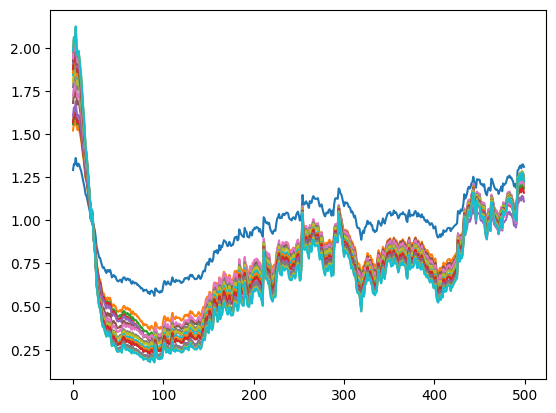

In [80]:
drapel_b_t = drapel_basin.copy()
for r in np.arange(0,20):
    rgi_m = drapel_b_t.isel(time=-1).volume.idxmax(dim='rgi_id').values[0]
    drapel_b_t = drapel_b_t.drop_sel(rgi_id=rgi_m)
    plt.plot(drapel_b_t.volume.sum(dim='rgi_id').squeeze()/drapel_b_t.volume.sum(dim='rgi_id').squeeze().sel(time=2020))


Text(0.5, 1.0, "['RGI60-17.01218']")

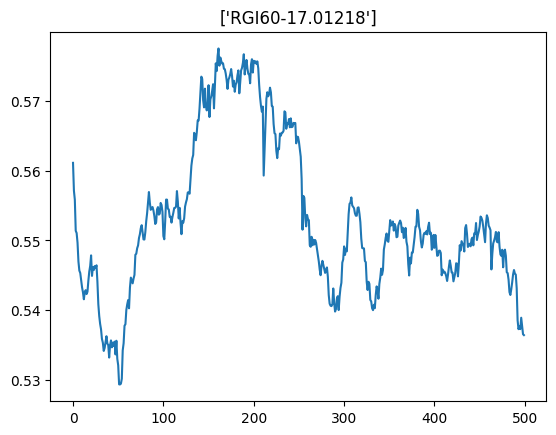

In [65]:
rgi_max = drapel_basin.isel(time=-1).volume.idxmax(dim='rgi_id').values[0]
plt.plot(drapel_basin.sel(rgi_id=rgi_max).volume.squeeze()/drapel_basin.volume.sum(dim='rgi_id').sel(time=0).squeeze())
plt.title(rgi_max)

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

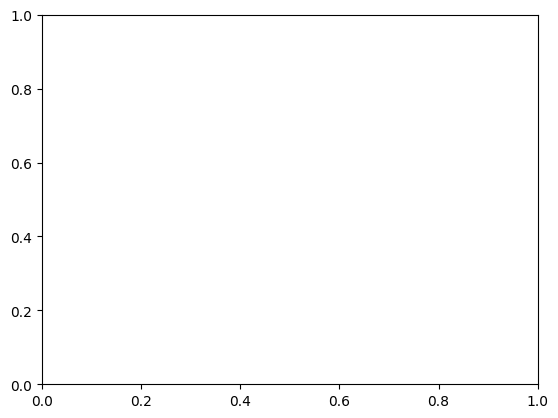

In [ ]:
'RGI60-17.15808'

<xarray.DataArray 'rgi_id' (scenario: 1, gcm: 1)>
array([['RGI60-17.15808']], dtype=object)
Coordinates:
    time             float64 2.499e+03
    hydro_year       int64 2499
    hydro_month      int64 10
    calendar_year    int64 2499
    calendar_month   int64 1
    bias_correction  <U12 'bc_1980_2019'
    provide_region   <U3 'P11'
    OGGM_version     <U22 'OGGM_v161_gdirs_2023.3'
    basin_id         (scenario, gcm) object '3429'
  * gcm              (gcm) object 'GFDL-ESM2M'
  * scenario         (scenario) object 'stab_T12'

In [22]:
ds_rep_sel.sel(rgi_id=ds_rep_sel.rgi_id.basin_id == str(basin)

SyntaxError: incomplete input (130774632.py, line 1)

In [21]:
ds_rep_sel_sum

<xarray.Dataset>
Dimensions:              (time: 500, month_2d: 12)
Coordinates:
  * time                 (time) float64 2e+03 2.001e+03 ... 2.498e+03 2.499e+03
    hydro_year           (time) int64 2000 2001 2002 2003 ... 2497 2498 2499
    hydro_month          (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10
    calendar_year        (time) int64 2000 2001 2002 2003 ... 2497 2498 2499
    calendar_month       (time) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
  * month_2d             (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d    (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    gcm                  <U10 'GFDL-ESM2M'
    scenario             <U8 'stab_T30'
    bias_correction      <U12 'bc_1980_2019'
    provide_region       <U3 'P11'
    OGGM_version         <U22 'OGGM_v161_gdirs_2023.3'
Data variables:
    runoff               (time) float64 6.807e+13 7.974e+13 ... 7.488e+13 0.0
    melt_off_on          (time) float64 5.201e+13 5.978e+13 ... 3.974e+13 0.0
    volume               (time) float64 5.148e+12 5.148e+12 ... 1.538e+12
    area                 (time) float64 2.981e+10 3.012e+10 ... 1.043e+10
    runoff_monthly       (time, month_2d) float64 1.927e+13 1.225e+13 ... 0.0
    melt_off_on_monthly  (time, month_2d) float64 1.556e+13 1.004e+13 ... 0.0
Attributes:
    description:                         OGGM model output
    oggm_version:                        1.6.1.dev26+gf8a1745
    calendar:                            365-day no leap
    creation_date:                       19/06/2023
    ratio_area_missing_filled_vs_total:  0.00280039335242556
    n_glaciers_missing_filled:           84
    provide_region:                      P11
    scenario:                            stab_T30
    information:                         OGGM v1.6.1 (v2023.3, W5E5_spinup)\n...

In [20]:
dtest

<xarray.Dataset>
Dimensions:              (scenario: 8, time: 500, month_2d: 12)
Coordinates:
  * time                 (time) float64 2e+03 2.001e+03 ... 2.498e+03 2.499e+03
    hydro_year           (time) int64 ...
    hydro_month          (time) int64 ...
    calendar_year        (time) int64 ...
    calendar_month       (time) int64 ...
  * month_2d             (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d    (month_2d) int64 ...
    gcm                  object ...
  * scenario             (scenario) object 'stab_T12' ... 'stab_T30'
    bias_correction      object ...
    provide_region       object ...
    OGGM_version         object ...
Data variables:
    runoff               (scenario, time) float64 ...
    melt_off_on          (scenario, time) float64 ...
    volume               (scenario, time) float64 ...
    area                 (scenario, time) float64 ...
    runoff_monthly       (scenario, time, month_2d) float64 ...
    melt_off_on_monthly  (scenario, time, month_2d) float64 ...

## OLD

In [44]:
today = '11/05/2023'

folder_path = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output/provide_reg/w5e5_gcm_merged_from_2000_bc_2000_2019/'

for Preg in ['P01']:
    print(f'Preg: {Preg} started')
    for scenario in scenarios:
        path = folder_path + f'provide_reg_P01_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_bc_2000_2019.nc'
        try:
            ds = xr.open_dataset(path)
        except:
            path = folder_path + f'RGI{rgi_reg}/{gcm}_{scenario}_{period}_stop.nc'
            ds = xr.open_dataset(path)
        ds = xr.open_dataset(path)
        ds = ds.rename_vars({'volume':'volume_m3'})
        ds = ds.rename_vars({'area':'area_m2'})
        ds = ds.rename_dims({'time':'simulation_year'})
        ds = ds[['volume_m3','area_m2']]

        ### very IMPORTANT--> THIS is much faster!!!
        ds = ds.load()
        rgi_reg_working = ds.volume_m3.isel(simulation_year=0).dropna(dim='rgi_id').rgi_id.values
        #bad_rgi = []
        #for r in rgidf_dict[rgi_reg].index:
        #    if r not in rgi_reg_working:
        #        bad_rgi.append(r)
        # this is much faster !!!
        bad_rgi = list(set(rgidf_dict[rgi_reg].index).difference(rgi_reg_working))

        bad = rgidf_dict[rgi_reg].loc[bad_rgi]  
        good = rgidf_dict[rgi_reg].loc[rgi_reg_working]  # working glaciers
        bad_ratio = bad.Area.sum() / good.Area.sum()
        #bad_glacier_count_perc = (len(bad)/len(good))
        #print('Correcting for {:.2f}% bad area'.format(bad_ratio * 100))
        assert len(bad)+len(good) == len(rgidf_dict[rgi_reg].index)

        # create dummy xarray dataset with empty data for the missing glaciers
        # that will be filled afterwards
        ds_dummy = ds.isel(rgi_id=0).load().copy(deep=True)
        ds_dummy['volume_m3'].data[...] = np.NaN
        ds_dummy['area_m2'].data[...] = np.NaN
        #ds_dummy = ds_dummy.drop('rgi_id')
        #ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index}).transpose()
        ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index.values}).transpose()
        # NEW: also need to add the coords values -> maybe 
        ds_dummy.coords['rgi_id'] = bad.index.values
        # add the dummy xarray dataset to the existing glaciers
        ds_sel_full = xr.concat([ds, ds_dummy], dim='rgi_id')

        # Repair the missing glaciers
        ds_rep_sel = ds_sel_full.copy(deep=True)
        ds_rep_sel = ds_rep_sel.squeeze()
        ds_index = ds_rep_sel.rgi_id.data
        # need to loop over every glacier 
        for rid, g in bad.iterrows():
            area_diff = np.abs(good.Area - g.Area) / g.Area
            # if possible, take all glacers of that RGI region that 
            # have a smaller relative area difference than 1 %
            sel = area_diff.loc[area_diff < 0.01]
            if len(sel) < 3:
                # if less than 3 glaciers have a similar area,
                # take instead the 9 area-most similar glaciers
                sel = area_diff.sort_values().iloc[:9]
            # Now, we take the average over the selected area-similar glaciers
            # and add them as fake statistics for that missing glacier
            # (in our case it is area and volume that that 
            # are estimated for each simulation year like that)
            new = ds.sel(rgi_id=sel.index).mean(dim='rgi_id').squeeze()
            rep_id = np.nonzero(ds_index == rid)[0][0]
            for vn in ds_rep_sel.data_vars:
                ds_rep_sel[vn].data[...,rep_id] = new[vn].data

        # Convert to f64 for exact summing
        ds_rep_sel = ds_rep_sel.astype(np.float64)
        # add some statistics about how much we had to fill up this RGI region
        ds_rep_sel.attrs['ratio_area_missing_filled_vs_working'] = bad_ratio #*100
        ds_rep_sel.attrs['n_glaciers_missing_filled'] = len(bad)

        # create a dataset that has the same form as the "raw" uncorrected dataset
        # but we add an information that the data was corrected
        ds_rep_sel.attrs['contributor'] = model_author
        ds_rep_sel.attrs['contributor_email'] = 'fabien.maussion@uibk.ac.at'
        ds_rep_sel.attrs['creation_date'] = str(today)
        ds_rep_sel.attrs['rgi-region'] = f'rgi{rgi_reg}'
        ds_rep_sel.attrs['aggregation-level'] = 'sum'
        ds_rep_sel.attrs['period'] = period
        ds_rep_sel.attrs['gcm'] = gcm
        ds_rep_sel.attrs['ssp'] = scenario
        # for gfdl I used the unofficial dev-branch that's why it can be different in the raw files
        # but the code should be the same
        #ds_rep_sel.attrs['oggm_version'] = '1.6' 
        add = ('\n(missing glaciers were filled by Lilian Schuster with average glacier' 
               'statistics from similar-area glaciers of that RGI region)')
        ds_rep_sel.attrs['information'] = 'OGGM test run w. stop criterion 1'+ add
        # check if there are any NaN values  (should not be the case, all glaciers should have been filled!)
        assert set(ds_rep_sel.dropna(dim='rgi_id', how='any').rgi_id.values) == set(rgidf_dict[rgi_reg].index)
        # we only keep the regional summed up filled files for the moment
        ds_rep_sel = ds_rep_sel.sum(dim='rgi_id', keep_attrs=True)

        ## save the data
        out_dir = '/home/users/lschuster/www_lschuster/glacierMIP3_analysis/OGGM_v16/regional_filled/'
        out_path = out_dir + f'{rgi_reg}/{model_author}_rgi{rgi_reg}_sum_{period}_{gcm}_{scenario}_filled.nc'
        mkdir(out_dir + rgi_reg)
        ds_rep_sel.to_netcdf(out_path)
        # close the datasets to be sure ... 
        ds_rep_sel.close()
        ds_sel_full.close()
        ds.close()

Preg: P01 started


NameError: name 'gcm' is not defined

In [2]:
rgidf_dict = {}
for rgi_reg in ['01','02']:
    path_rgi = oggm.utils.get_rgi_region_file(rgi_reg, version='6')
    rgidf = gpd.read_file(path_rgi)
    #Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    if rgi_reg == '05':
        rgidf = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
    rgidf_dict[rgi_reg] = rgidf
    rgidf_dict[rgi_reg] = rgidf_dict[rgi_reg].set_index('RGIId')

In [ ]:
today = '11/05/2023'

# get the RGI area / ITMIX volumes of the glaciers
p_regs = []
for p_reg in np.arange(1,14,1):
    if p_reg < 10:
        p_reg = '0'+str(p_reg)
    else:
        p_reg = str(p_reg)
    p_regs.append(p_reg)

df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
P_dict = {}
for p_reg in p_regs:
    path_rgi = oggm.utils.get_rgi_region_file(rgi_reg, version='6')
    rgidf = gpd.read_file(path_rgi)
    #Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    if rgi_reg == '05':
        rgidf = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
    rgidf_dict[rgi_reg] = rgidf
    rgidf_dict[rgi_reg] = rgidf_dict[rgi_reg].set_index('RGIId')
    
rgi_reg_sel = sys.argv[1]   
#rgi_reg_sel = '01'    
### get the per glacier volumes and areas for each rgi_region, period, scenario and gcm: 
### then estimate which glaciers are missing and get the missing_vs_working rgi area
### we also have to enlarge our dataset with the missing glaciers (first just put NaN values inside, those will be filled later)
### then fill the missing glaciers with the mean statistics from glaciers with a relative glacier area difference of less than 1%
#folder_path = '/home/www/drounce/per_glacier/'
folder_path = f'/home/www/lschuster/runs_glacierMIP3_oggm_v16/output/' #RGI{rgi_reg}/{gcm}_historical_1851-1870.nc'

for rgi_reg in [rgi_reg_sel]:
    print(f'rgi_reg: {rgi_reg} started')
    for y0_time in y0_times:
        period = f'{y0_time}-{y0_time+19}'
        if y0_time in [1851, 1901, 1951, 1995]:
            scenarios_sel = ['historical']
        else:
            scenarios_sel = scenarios[1:]
        # just because I have to repeat the 1995 again !!!
        for scenario in scenarios_sel:
            for gcm in gcms:
                #path = folder_path + f'{rgi_reg}/{model_author}_rgi{rgi_reg}_glaciers_{period}_{gcm}_{scenario}*.nc'
                path = folder_path + f'RGI{rgi_reg}/{gcm}_{scenario}_{period}.nc'
                try:
                    ds = xr.open_dataset(path)
                except:
                    path = folder_path + f'RGI{rgi_reg}/{gcm}_{scenario}_{period}_stop.nc'
                    ds = xr.open_dataset(path)
                ds = xr.open_dataset(path)
                ds = ds.rename_vars({'volume':'volume_m3'})
                ds = ds.rename_vars({'area':'area_m2'})
                ds = ds.rename_dims({'time':'simulation_year'})
                ds = ds[['volume_m3','area_m2']]

                ### very IMPORTANT--> THIS is much faster!!!
                ds = ds.load()
                rgi_reg_working = ds.volume_m3.isel(simulation_year=0).dropna(dim='rgi_id').rgi_id.values
                #bad_rgi = []
                #for r in rgidf_dict[rgi_reg].index:
                #    if r not in rgi_reg_working:
                #        bad_rgi.append(r)
                # this is much faster !!!
                bad_rgi = list(set(rgidf_dict[rgi_reg].index).difference(rgi_reg_working))

                bad = rgidf_dict[rgi_reg].loc[bad_rgi]  
                good = rgidf_dict[rgi_reg].loc[rgi_reg_working]  # working glaciers
                bad_ratio = bad.Area.sum() / good.Area.sum()
                #bad_glacier_count_perc = (len(bad)/len(good))
                #print('Correcting for {:.2f}% bad area'.format(bad_ratio * 100))
                assert len(bad)+len(good) == len(rgidf_dict[rgi_reg].index)
                
                # create dummy xarray dataset with empty data for the missing glaciers
                # that will be filled afterwards
                ds_dummy = ds.isel(rgi_id=0).load().copy(deep=True)
                ds_dummy['volume_m3'].data[...] = np.NaN
                ds_dummy['area_m2'].data[...] = np.NaN
                #ds_dummy = ds_dummy.drop('rgi_id')
                #ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index}).transpose()
                ds_dummy = ds_dummy.expand_dims({'rgi_id':bad.index.values}).transpose()
                # NEW: also need to add the coords values -> maybe 
                ds_dummy.coords['rgi_id'] = bad.index.values
                # add the dummy xarray dataset to the existing glaciers
                ds_sel_full = xr.concat([ds, ds_dummy], dim='rgi_id')

                # Repair the missing glaciers
                ds_rep_sel = ds_sel_full.copy(deep=True)
                ds_rep_sel = ds_rep_sel.squeeze()
                ds_index = ds_rep_sel.rgi_id.data
                # need to loop over every glacier 
                for rid, g in bad.iterrows():
                    area_diff = np.abs(good.Area - g.Area) / g.Area
                    # if possible, take all glacers of that RGI region that 
                    # have a smaller relative area difference than 1 %
                    sel = area_diff.loc[area_diff < 0.01]
                    if len(sel) < 3:
                        # if less than 3 glaciers have a similar area,
                        # take instead the 9 area-most similar glaciers
                        sel = area_diff.sort_values().iloc[:9]
                    # Now, we take the average over the selected area-similar glaciers
                    # and add them as fake statistics for that missing glacier
                    # (in our case it is area and volume that that 
                    # are estimated for each simulation year like that)
                    new = ds.sel(rgi_id=sel.index).mean(dim='rgi_id').squeeze()
                    rep_id = np.nonzero(ds_index == rid)[0][0]
                    for vn in ds_rep_sel.data_vars:
                        ds_rep_sel[vn].data[...,rep_id] = new[vn].data

                # Convert to f64 for exact summing
                ds_rep_sel = ds_rep_sel.astype(np.float64)
                # add some statistics about how much we had to fill up this RGI region
                ds_rep_sel.attrs['ratio_area_missing_filled_vs_working'] = bad_ratio #*100
                ds_rep_sel.attrs['n_glaciers_missing_filled'] = len(bad)

                # create a dataset that has the same form as the "raw" uncorrected dataset
                # but we add an information that the data was corrected
                ds_rep_sel.attrs['contributor'] = model_author
                ds_rep_sel.attrs['contributor_email'] = 'fabien.maussion@uibk.ac.at'
                ds_rep_sel.attrs['creation_date'] = str(today)
                ds_rep_sel.attrs['rgi-region'] = f'rgi{rgi_reg}'
                ds_rep_sel.attrs['aggregation-level'] = 'sum'
                ds_rep_sel.attrs['period'] = period
                ds_rep_sel.attrs['gcm'] = gcm
                ds_rep_sel.attrs['ssp'] = scenario
                # for gfdl I used the unofficial dev-branch that's why it can be different in the raw files
                # but the code should be the same
                #ds_rep_sel.attrs['oggm_version'] = '1.6' 
                add = ('\n(missing glaciers were filled by Lilian Schuster with average glacier' 
                       'statistics from similar-area glaciers of that RGI region)')
                ds_rep_sel.attrs['information'] = 'OGGM test run w. stop criterion 1'+ add
                # check if there are any NaN values  (should not be the case, all glaciers should have been filled!)
                assert set(ds_rep_sel.dropna(dim='rgi_id', how='any').rgi_id.values) == set(rgidf_dict[rgi_reg].index)
                # we only keep the regional summed up filled files for the moment
                ds_rep_sel = ds_rep_sel.sum(dim='rgi_id', keep_attrs=True)
                
                ## save the data
                out_dir = '/home/users/lschuster/www_lschuster/glacierMIP3_analysis/OGGM_v16/regional_filled/'
                out_path = out_dir + f'{rgi_reg}/{model_author}_rgi{rgi_reg}_sum_{period}_{gcm}_{scenario}_filled.nc'
                mkdir(out_dir + rgi_reg)
                ds_rep_sel.to_netcdf(out_path)
                # close the datasets to be sure ... 
                ds_rep_sel.close()
                ds_sel_full.close()
                ds.close()